In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pandas as pd
import numpy as np
import datetime as dt 
import yfinance as yf
import pandas_ta as ta
import warnings
import urllib.request
warnings.filterwarnings('ignore')

### Acess wikipedia page and get table of companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Define the User-Agent header to access wikipedia 
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'
}

# Create a request object with the URL and the headers
req = urllib.request.Request(url=url, headers=headers)

# Fetch the raw HTML with urllib
with urllib.request.urlopen(req) as response:
    html = response.read()

# Parse the tables from the HTML
list_of_tables = pd.read_html(html)

# Select the first table
sp500_table = list_of_tables[0]

# Checkpoint
print("S&P 500 Companies Table:")
print(sp500_table.head())

# Some symbols have '.' which need to be changed to '-'
sp500_table['Symbol'] = sp500_table['Symbol'].str.replace('.', '-', regex=False)

symbols_list = sp500_table['Symbol'].unique().tolist()

# Check we have correct list of symbols
print(symbols_list)
print('-' * 30)
print()

# Make end date today
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

# Make start date 8 years before end date
start_date = pd.to_datetime(end_date) - pd.DateOffset(365 * 8)

# Checkpoint
print('Your start date is:', start_date)
print('Your end date is:', end_date)

S&P 500 Companies Table:
  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  
['MMM', 'AOS', 'ABT', 'ABBV', '

In [2]:
df = yf.download(
    tickers=symbols_list,
    start=start_date,
    end=end_date,
    auto_adjust=False
).stack()
df

[*********************100%***********************]  503 of 503 completed


Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2017-09-21 A        62.055786   65.919998   66.139999   65.629997   65.879997   
           AAPL     35.828716   38.347500   38.950001   38.187500   38.950001   
           ABBV     62.102573   87.410004   87.699997   86.669998   87.360001   
           ABT      44.665783   51.430000   51.980000   51.380001   51.880001   
           ACGL     31.091211   32.696667   32.706669   32.060001   32.063332   
...                       ...         ...         ...         ...         ...   
2025-09-18 XYZ      77.370003   77.370003   78.300003   75.760002   76.199997   
           YUM     145.259995  145.259995  147.839996  144.800003  146.630005   
           ZBH     100.209999  100.209999  101.300003   98.449997  100.739998   
           ZBRA    322.880005  322.880005  325.239990  321.279999  321.839996   
           ZTS     147.100006  147.100006  148.039993  145.149994  146.300003   

Price                   Volume  
Date       Ticker               
2017-09-21 A          874800.0  
           AAPL    150046800.0  
           ABBV      7340300.0  
           ABT       5737600.0  
           ACGL      1090200.0  
...                        ...  
2025-09-18 XYZ       5440000.0  
           YUM       1747400.0  
           ZBH       1304500.0  
           ZBRA       479400.0  
           ZTS       2739400.0  

[993135 rows x 6 columns]

In [3]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-09-21 A        62.055786   65.919998   66.139999   65.629997   65.879997   
           AAPL     35.828716   38.347500   38.950001   38.187500   38.950001   
           ABBV     62.102573   87.410004   87.699997   86.669998   87.360001   
           ABT      44.665783   51.430000   51.980000   51.380001   51.880001   
           ACGL     31.091211   32.696667   32.706669   32.060001   32.063332   
...                       ...         ...         ...         ...         ...   
2025-09-18 XYZ      77.370003   77.370003   78.300003   75.760002   76.199997   
           YUM     145.259995  145.259995  147.839996  144.800003  146.630005   
           ZBH     100.209999  100.209999  101.300003   98.449997  100.739998   
           ZBRA    322.880005  322.880005  325.239990  321.279999  321.839996   
           ZTS     147.100006  147.100006  148.039993  145.149994  146.300003   

Price                   volume  
date       ticker               
2017-09-21 A          874800.0  
           AAPL    150046800.0  
           ABBV      7340300.0  
           ABT       5737600.0  
           ACGL      1090200.0  
...                        ...  
2025-09-18 XYZ       5440000.0  
           YUM       1747400.0  
           ZBH       1304500.0  
           ZBRA       479400.0  
           ZTS       2739400.0  

[993135 rows x 6 columns]

In [4]:
# Calculate Garman-Klass Volitility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-09-21 A        62.055786   65.919998   66.139999   65.629997   65.879997   
           AAPL     35.828716   38.347500   38.950001   38.187500   38.950001   
           ABBV     62.102573   87.410004   87.699997   86.669998   87.360001   
           ABT      44.665783   51.430000   51.980000   51.380001   51.880001   
           ACGL     31.091211   32.696667   32.706669   32.060001   32.063332   
...                       ...         ...         ...         ...         ...   
2025-09-18 XYZ      77.370003   77.370003   78.300003   75.760002   76.199997   
           YUM     145.259995  145.259995  147.839996  144.800003  146.630005   
           ZBH     100.209999  100.209999  101.300003   98.449997  100.739998   
           ZBRA    322.880005  322.880005  325.239990  321.279999  321.839996   
           ZTS     147.100006  147.100006  148.039993  145.149994  146.300003   

Price                   volume  garman_klass_vol  
date       ticker                                 
2017-09-21 A          874800.0         -0.001351  
           AAPL    150046800.0         -0.002500  
           ABBV      7340300.0         -0.044915  
           ABT       5737600.0         -0.008592  
           ACGL      1090200.0         -0.000167  
...                        ...               ...  
2025-09-18 XYZ       5440000.0          0.000454  
           YUM       1747400.0          0.000182  
           ZBH       1304500.0          0.000396  
           ZBRA       479400.0          0.000071  
           ZTS       2739400.0          0.000183  

[993135 rows x 7 columns]

In [5]:
# Calculate RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.rsi(close=x, length = 20))
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-09-21 A        62.055786   65.919998   66.139999   65.629997   65.879997   
           AAPL     35.828716   38.347500   38.950001   38.187500   38.950001   
           ABBV     62.102573   87.410004   87.699997   86.669998   87.360001   
           ABT      44.665783   51.430000   51.980000   51.380001   51.880001   
           ACGL     31.091211   32.696667   32.706669   32.060001   32.063332   
...                       ...         ...         ...         ...         ...   
2025-09-18 XYZ      77.370003   77.370003   78.300003   75.760002   76.199997   
           YUM     145.259995  145.259995  147.839996  144.800003  146.630005   
           ZBH     100.209999  100.209999  101.300003   98.449997  100.739998   
           ZBRA    322.880005  322.880005  325.239990  321.279999  321.839996   
           ZTS     147.100006  147.100006  148.039993  145.149994  146.300003   

Price                   volume  garman_klass_vol        rsi  
date       ticker                                            
2017-09-21 A          874800.0         -0.001351        NaN  
           AAPL    150046800.0         -0.002500        NaN  
           ABBV      7340300.0         -0.044915        NaN  
           ABT       5737600.0         -0.008592        NaN  
           ACGL      1090200.0         -0.000167        NaN  
...                        ...               ...        ...  
2025-09-18 XYZ       5440000.0          0.000454  55.273299  
           YUM       1747400.0          0.000182  48.253485  
           ZBH       1304500.0          0.000396  47.641594  
           ZBRA       479400.0          0.000071  53.361285  
           ZTS       2739400.0          0.000183  41.206249  

[993135 rows x 8 columns]

<Axes: xlabel='date'>

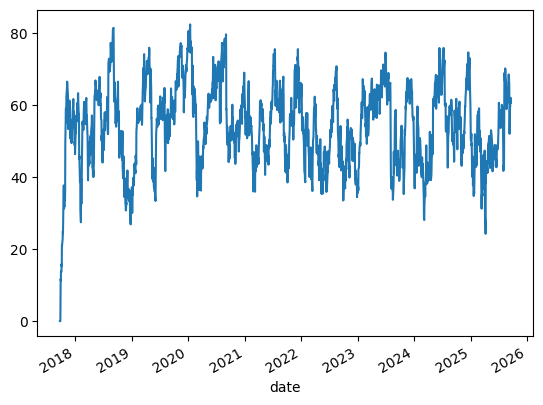

In [6]:
df.xs('AAPL', level =1)['rsi'].plot()

In [7]:
ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
date,,,,,
2017-09-21,NaN,NaN,NaN,NaN,NaN
2017-09-22,NaN,NaN,NaN,NaN,NaN
2017-09-25,NaN,NaN,NaN,NaN,NaN
2017-09-26,NaN,NaN,NaN,NaN,NaN
2017-09-27,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-09-12,222.973241,231.707500,240.441758,7.539038,0.635244
2025-09-15,222.962533,231.963000,240.963466,7.760260,0.763153
2025-09-16,222.950135,232.325999,241.701864,8.071300,0.810584


In [8]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-09-21 A        62.055786   65.919998   66.139999   65.629997   65.879997   
           AAPL     35.828716   38.347500   38.950001   38.187500   38.950001   
           ABBV     62.102573   87.410004   87.699997   86.669998   87.360001   
           ABT      44.665783   51.430000   51.980000   51.380001   51.880001   
           ACGL     31.091211   32.696667   32.706669   32.060001   32.063332   
...                       ...         ...         ...         ...         ...   
2025-09-18 XYZ      77.370003   77.370003   78.300003   75.760002   76.199997   
           YUM     145.259995  145.259995  147.839996  144.800003  146.630005   
           ZBH     100.209999  100.209999  101.300003   98.449997  100.739998   
           ZBRA    322.880005  322.880005  325.239990  321.279999  321.839996   
           ZTS     147.100006  147.100006  148.039993  145.149994  146.300003   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-09-21 A          874800.0         -0.001351        NaN       NaN   
           AAPL    150046800.0         -0.002500        NaN       NaN   
           ABBV      7340300.0         -0.044915        NaN       NaN   
           ABT       5737600.0         -0.008592        NaN       NaN   
           ACGL      1090200.0         -0.000167        NaN       NaN   
...                        ...               ...        ...       ...   
2025-09-18 XYZ       5440000.0          0.000454  55.273299  4.292723   
           YUM       1747400.0          0.000182  48.253485  4.971011   
           ZBH       1304500.0          0.000396  47.641594  4.607826   
           ZBRA       479400.0          0.000071  53.361285  5.721989   
           ZTS       2739400.0          0.000183  41.206249  4.985449   

Price                bb_mid   bb_high  
date       ticker                      
2017-09-21 A            NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
           ACGL         NaN       NaN  
...                     ...       ...  
2025-09-18 XYZ     4.349398  4.406072  
           YUM     4.993661  5.016311  
           ZBH     4.655528  4.703230  
           ZBRA    5.757188  5.792387  
           ZTS     5.029577  5.073705  

[993135 rows x 11 columns]

In [9]:
def compute_atr(stock_data):
    atr = ta.atr(high=stock_data['high'],
                 low=stock_data['low'],
                 close=stock_data['close'],
                 length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-09-21 A        62.055786   65.919998   66.139999   65.629997   65.879997   
           AAPL     35.828716   38.347500   38.950001   38.187500   38.950001   
           ABBV     62.102573   87.410004   87.699997   86.669998   87.360001   
           ABT      44.665783   51.430000   51.980000   51.380001   51.880001   
           ACGL     31.091211   32.696667   32.706669   32.060001   32.063332   
...                       ...         ...         ...         ...         ...   
2025-09-18 XYZ      77.370003   77.370003   78.300003   75.760002   76.199997   
           YUM     145.259995  145.259995  147.839996  144.800003  146.630005   
           ZBH     100.209999  100.209999  101.300003   98.449997  100.739998   
           ZBRA    322.880005  322.880005  325.239990  321.279999  321.839996   
           ZTS     147.100006  147.100006  148.039993  145.149994  146.300003   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-09-21 A          874800.0         -0.001351        NaN       NaN   
           AAPL    150046800.0         -0.002500        NaN       NaN   
           ABBV      7340300.0         -0.044915        NaN       NaN   
           ABT       5737600.0         -0.008592        NaN       NaN   
           ACGL      1090200.0         -0.000167        NaN       NaN   
...                        ...               ...        ...       ...   
2025-09-18 XYZ       5440000.0          0.000454  55.273299  4.292723   
           YUM       1747400.0          0.000182  48.253485  4.971011   
           ZBH       1304500.0          0.000396  47.641594  4.607826   
           ZBRA       479400.0          0.000071  53.361285  5.721989   
           ZTS       2739400.0          0.000183  41.206249  4.985449   

Price                bb_mid   bb_high       atr  
date       ticker                                
2017-09-21 A            NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN  
...                     ...       ...       ...  
2025-09-18 XYZ     4.349398  4.406072 -0.718385  
           YUM     4.993661  5.016311  0.737347  
           ZBH     4.655528  4.703230 -0.730905  
           ZBRA    5.757188  5.792387 -0.092245  
           ZTS     5.029577  5.073705 -0.206411  

[993135 rows x 12 columns]

In [10]:

def compute_macd(close):
    macd = ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-09-21 A        62.055786   65.919998   66.139999   65.629997   65.879997   
           AAPL     35.828716   38.347500   38.950001   38.187500   38.950001   
           ABBV     62.102573   87.410004   87.699997   86.669998   87.360001   
           ABT      44.665783   51.430000   51.980000   51.380001   51.880001   
           ACGL     31.091211   32.696667   32.706669   32.060001   32.063332   
...                       ...         ...         ...         ...         ...   
2025-09-18 XYZ      77.370003   77.370003   78.300003   75.760002   76.199997   
           YUM     145.259995  145.259995  147.839996  144.800003  146.630005   
           ZBH     100.209999  100.209999  101.300003   98.449997  100.739998   
           ZBRA    322.880005  322.880005  325.239990  321.279999  321.839996   
           ZTS     147.100006  147.100006  148.039993  145.149994  146.300003   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-09-21 A          874800.0         -0.001351        NaN       NaN   
           AAPL    150046800.0         -0.002500        NaN       NaN   
           ABBV      7340300.0         -0.044915        NaN       NaN   
           ABT       5737600.0         -0.008592        NaN       NaN   
           ACGL      1090200.0         -0.000167        NaN       NaN   
...                        ...               ...        ...       ...   
2025-09-18 XYZ       5440000.0          0.000454  55.273299  4.292723   
           YUM       1747400.0          0.000182  48.253485  4.971011   
           ZBH       1304500.0          0.000396  47.641594  4.607826   
           ZBRA       479400.0          0.000071  53.361285  5.721989   
           ZTS       2739400.0          0.000183  41.206249  4.985449   

Price                bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-09-21 A            NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2025-09-18 XYZ     4.349398  4.406072 -0.718385 -0.031286  
           YUM     4.993661  5.016311  0.737347  0.179891  
           ZBH     4.655528  4.703230 -0.730905  0.000171  
           ZBRA    5.757188  5.792387 -0.092245 -0.104219  
           ZTS     5.029577  5.073705 -0.206411 -0.756120  

[993135 rows x 13 columns]

In [11]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1000000
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-09-21 A        62.055786   65.919998   66.139999   65.629997   65.879997   
           AAPL     35.828716   38.347500   38.950001   38.187500   38.950001   
           ABBV     62.102573   87.410004   87.699997   86.669998   87.360001   
           ABT      44.665783   51.430000   51.980000   51.380001   51.880001   
           ACGL     31.091211   32.696667   32.706669   32.060001   32.063332   
...                       ...         ...         ...         ...         ...   
2025-09-18 XYZ      77.370003   77.370003   78.300003   75.760002   76.199997   
           YUM     145.259995  145.259995  147.839996  144.800003  146.630005   
           ZBH     100.209999  100.209999  101.300003   98.449997  100.739998   
           ZBRA    322.880005  322.880005  325.239990  321.279999  321.839996   
           ZTS     147.100006  147.100006  148.039993  145.149994  146.300003   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-09-21 A          874800.0         -0.001351        NaN       NaN   
           AAPL    150046800.0         -0.002500        NaN       NaN   
           ABBV      7340300.0         -0.044915        NaN       NaN   
           ABT       5737600.0         -0.008592        NaN       NaN   
           ACGL      1090200.0         -0.000167        NaN       NaN   
...                        ...               ...        ...       ...   
2025-09-18 XYZ       5440000.0          0.000454  55.273299  4.292723   
           YUM       1747400.0          0.000182  48.253485  4.971011   
           ZBH       1304500.0          0.000396  47.641594  4.607826   
           ZBRA       479400.0          0.000071  53.361285  5.721989   
           ZTS       2739400.0          0.000183  41.206249  4.985449   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-09-21 A            NaN       NaN       NaN       NaN      54.286402  
           AAPL         NaN       NaN       NaN       NaN    5375.984226  
           ABBV         NaN       NaN       NaN       NaN     455.851519  
           ABT          NaN       NaN       NaN       NaN     256.274396  
           ACGL         NaN       NaN       NaN       NaN      33.895639  
...                     ...       ...       ...       ...            ...  
2025-09-18 XYZ     4.349398  4.406072 -0.718385 -0.031286     420.892815  
           YUM     4.993661  5.016311  0.737347  0.179891     253.827314  
           ZBH     4.655528  4.703230 -0.730905  0.000171     130.723944  
           ZBRA    5.757188  5.792387 -0.092245 -0.104219     154.788674  
           ZTS     5.029577  5.073705 -0.206411 -0.756120     402.965757  

[993135 rows x 14 columns]

In [12]:
'''
Aggregate monthyly date and filter top 150 most liquid stocks for every month
Aggregate all indicators and take the end value for the month and adjusted close price
For dollar volume get average dollar volume for whole month for each stock
Purpose is to reduce learning time for MLM
'''
# Isolate technical indicator columns
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), 
          df.unstack()[last_cols].resample('M').last().stack('ticker')],
          axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-10-31 A           90.095145   64.174026         -0.001087  57.472673   
           AAPL      3402.314637   39.484234         -0.001316  59.062291   
           ABBV       417.244841   64.567642         -0.044945  51.230589   
           ABT        272.129835   47.327896         -0.007607  74.421885   
           ACGL        49.101617   31.582510         -0.000997  50.709993   
...                          ...         ...               ...        ...   
2025-09-30 XYZ        394.029239   77.370003          0.000454  55.273299   
           YUM        283.360186  145.259995          0.000182  48.253485   
           ZBH        131.385393  100.209999          0.000396  47.641594   
           ZBRA       158.362626  322.880005          0.000071  53.361285   
           ZTS        372.225613  147.100006          0.000183  41.206249   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-10-31 A       4.142041  4.161062  4.180084 -1.857410  0.290804  
           AAPL    3.589090  3.635955  3.682820 -1.407709 -0.000495  
           ABBV    4.153099  4.199430  4.245761 -0.231343  0.174256  
           ABT     3.868742  3.892300  3.915859 -1.664738  0.212255  
           ACGL    3.464891  3.488365  3.511840 -1.276795 -0.002736  
...                     ...       ...       ...       ...       ...  
2025-09-30 XYZ     4.292723  4.349398  4.406072 -0.718385 -0.031286  
           YUM     4.971011  4.993661  5.016311  0.737347  0.179891  
           ZBH     4.607826  4.655528  4.703230 -0.730905  0.000171  
           ZBRA    5.721989  5.757188  5.792387 -0.092245 -0.104219  
           ZTS     4.985449  5.029577  5.073705 -0.206411 -0.756120  

[47448 rows x 9 columns]

In [13]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-10-31 A                 NaN   64.174026         -0.001087  57.472673   
           AAPL              NaN   39.484234         -0.001316  59.062291   
           ABBV              NaN   64.567642         -0.044945  51.230589   
           ABT               NaN   47.327896         -0.007607  74.421885   
           ACGL              NaN   31.582510         -0.000997  50.709993   
...                          ...         ...               ...        ...   
2025-09-30 XYZ       1181.961699   77.370003          0.000454  55.273299   
           YUM        217.023025  145.259995          0.000182  48.253485   
           ZBH        180.410608  100.209999          0.000396  47.641594   
           ZBRA       136.524550  322.880005          0.000071  53.361285   
           ZTS        372.437746  147.100006          0.000183  41.206249   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-10-31 A       4.142041  4.161062  4.180084 -1.857410  0.290804  
           AAPL    3.589090  3.635955  3.682820 -1.407709 -0.000495  
           ABBV    4.153099  4.199430  4.245761 -0.231343  0.174256  
           ABT     3.868742  3.892300  3.915859 -1.664738  0.212255  
           ACGL    3.464891  3.488365  3.511840 -1.276795 -0.002736  
...                     ...       ...       ...       ...       ...  
2025-09-30 XYZ     4.292723  4.349398  4.406072 -0.718385 -0.031286  
           YUM     4.971011  4.993661  5.016311  0.737347  0.179891  
           ZBH     4.607826  4.655528  4.703230 -0.730905  0.000171  
           ZBRA    5.721989  5.757188  5.792387 -0.092245 -0.104219  
           ZTS     4.985449  5.029577  5.073705 -0.206411 -0.756120  

[47448 rows x 9 columns]

In [14]:
# Calculate dollar volume rank cross sectionally by month
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-09-30 AAPL     53.525421         -0.000884  61.186115  3.953861   
           ABBV     69.559952         -0.034926  49.718793  4.223081   
           ABT      64.929497         -0.004971  79.127225  4.054769   
           ACN     152.580551         -0.004457  54.490893  5.019864   
           ADBE    269.950012          0.000100  56.971091  5.555771   
...                       ...               ...        ...       ...   
2025-09-30 WDAY    233.500000          0.000455  53.400461  5.394523   
           WFC      83.500000          0.000134  59.793687  4.372866   
           WMT     103.599998          0.000296  59.922158  4.556120   
           XOM     113.930000          0.000100  57.931895  4.699774   
           XYZ      77.370003          0.000454  55.273299  4.292723   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-09-30 AAPL    3.983711  4.013561 -1.157573 -0.043132  
           ABBV    4.250270  4.277459 -1.000433 -0.402510  
           ABT     4.123610  4.192450 -1.527052  1.043605  
           ACN     5.039856  5.059848 -1.450365  0.179738  
           ADBE    5.587446  5.619120 -1.228467  0.189348  
...                     ...       ...       ...       ...  
2025-09-30 WDAY    5.433078  5.471633  0.386123 -0.093036  
           WFC     4.406614  4.440362  0.991736  0.610539  
           WMT     4.615136  4.674152  1.813194  1.420144  
           XOM     4.729886  4.759998  0.026299  0.824588  
           XYZ     4.349398  4.406072 -0.718385 -0.031286  

[12665 rows x 8 columns]

In [15]:
# Calculate monthly returns for different time horizons and add them as additional features
# Do this to capture time series dynamics that
# May reflect momentum patterns for each stock
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                    upper=x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-09-30 AAPL     53.929813         -0.000073  60.753842  3.936588   
           ABBV     58.610992         -0.023164  69.713196  3.938414   
           ABT      75.290619         -0.002621  49.178251  4.311257   
           ACN     175.454895         -0.002904  48.714200  5.152077   
           ADBE    276.250000          0.000089  44.473157  5.611829   
...                       ...               ...        ...       ...   
2025-09-30 WDAY    233.500000          0.000455  53.400461  5.394523   
           WFC      83.500000          0.000134  59.793687  4.372866   
           WMT     103.599998          0.000296  59.922158  4.556120   
           XOM     113.930000          0.000100  57.931895  4.699774   
           XYZ      77.370003          0.000454  55.273299  4.292723   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-09-30 AAPL    3.979289  4.021990 -1.162652  0.043423   0.072961   
           ABBV    4.018399  4.098385 -1.253721  0.483451   0.151810   
           ABT     4.335812  4.360367 -0.617212 -0.585126  -0.019339   
           ACN     5.181646  5.211215 -0.783069 -0.233106  -0.029369   
           ADBE    5.638405  5.664982 -0.843748 -0.341022  -0.029032   
...                     ...       ...       ...       ...        ...   
2025-09-30 WDAY    5.433078  5.471633  0.386123 -0.093036   0.011611   
           WFC     4.406614  4.440362  0.991736  0.610539   0.016062   
           WMT     4.615136  4.674152  1.813194  1.420144   0.068261   
           XOM     4.729886  4.759998  0.026299  0.824588  -0.003150   
           XYZ     4.349398  4.406072 -0.718385 -0.031286  -0.028503   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-09-30 AAPL     0.027278   0.043396   0.029148   0.041098    0.000627  
           ABBV     0.066112   0.018692  -0.005655  -0.017218   -0.011706  
           ABT     -0.019888  -0.000463   0.008944   0.017721    0.012414  
           ACN     -0.000597   0.013492   0.016293   0.036050    0.011709  
           ADBE    -0.038571  -0.021265   0.006013   0.022438    0.001924  
...                      ...        ...        ...        ...         ...  
2025-09-30 WDAY     0.008941  -0.009111  -0.000021  -0.011038   -0.003798  
           WFC      0.020627   0.015850   0.027441   0.021243    0.034997  
           WMT      0.029480   0.020252   0.028796   0.016167    0.021808  
           XOM      0.014893   0.021756  -0.004078   0.009464    0.000588  
           XYZ      0.000712   0.044328   0.060691  -0.010383    0.011901  

[10450 rows x 14 columns]

In [16]:
'''
Download Fama-Frech Factors and Calculate Rolling Factor Betas
Want to introduce Fama-French data to  estimate exposure of our assets
to commonly know risk factors using regressing rolling OS model

Five factors of Fama-French model are:

Market Risk - represents the excess return of the overall market over a 
risk-free rate.It assumes that investors are rewarded with higher returns for taking
on higher market-wide risk

Size ("Small Minus Big") - reflects the excess return of small-cap stocks over large-cap 
stocks. The model suggests that smaller companies historically deliver higher returns to 
compensate for their greater risk.

Value (HML: High Minus Low) - measures the excess return of "value" stocks over "growth" stocks.
Value stocks, characterized by high book-to-market ratios, are thought to outperform 
growth stocks over the long term.

Profitability (RMW: Robust minus weak) - measures the excess return of highly profitable 
companies over unprofitable ones. The model indicates that companies with high 
operating profitability tend to have higher returns

Investment (CMA: Conservative minus aggressive) - captures the difference in returns 
between companies that invest conservatively and those that invest aggressively. 
Companies with conservative investment strategies (low total asset growth) tend to 
outperform those that invest more aggressively (high total asset growth)
'''
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 AAPL    0.0142  0.0029  0.0676  0.0182  0.0338   0.072961
           ABBV    0.0142  0.0029  0.0676  0.0182  0.0338   0.151810
           ABT     0.0142  0.0029  0.0676  0.0182  0.0338  -0.019339
           ACN     0.0142  0.0029  0.0676  0.0182  0.0338  -0.029369
           ADBE    0.0142  0.0029  0.0676  0.0182  0.0338  -0.029032
...                   ...     ...     ...     ...     ...        ...
2025-06-30 WDAY    0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.031125
           WFC     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.071410
           WMT     0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.009522
           XOM     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053763
           XYZ     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.100081

[10027 rows x 6 columns]

In [17]:
# Filter out stocks that hae less than 10 months of data
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 AAPL    0.0142  0.0029  0.0676  0.0182  0.0338   0.072961
           ABBV    0.0142  0.0029  0.0676  0.0182  0.0338   0.151810
           ABT     0.0142  0.0029  0.0676  0.0182  0.0338  -0.019339
           ACN     0.0142  0.0029  0.0676  0.0182  0.0338  -0.029369
           ADBE    0.0142  0.0029  0.0676  0.0182  0.0338  -0.029032
...                   ...     ...     ...     ...     ...        ...
2025-06-30 WDAY    0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.031125
           WFC     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.071410
           WMT     0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.009522
           XOM     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053763
           XYZ     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.100081

[9963 rows x 6 columns]

In [18]:
# Calculate rolling factor betas
betas = (factor_data.groupby(level=1,
                    group_keys=False)
 .apply(lambda x: RollingOLS(endog=x['return_1m'],
                             exog=sm.add_constant(x.drop('return_1m', axis=1)),
                             window=min(24, x.shape[0]),
                             min_nobs=len(x.columns)+1)
.fit(params_only=True)
.params
.drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-09-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-06-30 WDAY    1.156298 -1.233651  0.737005 -1.551159 -0.530020
           WFC     0.800625 -0.092903  0.524113 -1.716526 -0.053749
           WMT     0.551378  0.107179 -0.390095  0.259687 -0.913335
           XOM     0.330550 -0.272277  0.873621  0.680353  0.249377
           XYZ     2.112164  0.214976  0.079686 -4.297201 -0.208419

[9963 rows x 5 columns]

In [19]:
# Join betas for full features dataset
data = data.join(betas.groupby('ticker').shift())
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-09-30 AAPL     53.929813         -0.000073  60.753842  3.936588   
           ABBV     58.610992         -0.023164  69.713196  3.938414   
           ABT      75.290619         -0.002621  49.178251  4.311257   
           ACN     175.454895         -0.002904  48.714200  5.152077   
           ADBE    276.250000          0.000089  44.473157  5.611829   
...                       ...               ...        ...       ...   
2025-09-30 WDAY    233.500000          0.000455  53.400461  5.394523   
           WFC      83.500000          0.000134  59.793687  4.372866   
           WMT     103.599998          0.000296  59.922158  4.556120   
           XOM     113.930000          0.000100  57.931895  4.699774   
           XYZ      77.370003          0.000454  55.273299  4.292723   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-09-30 AAPL    3.979289  4.021990 -1.162652  0.043423   0.072961   
           ABBV    4.018399  4.098385 -1.253721  0.483451   0.151810   
           ABT     4.335812  4.360367 -0.617212 -0.585126  -0.019339   
           ACN     5.181646  5.211215 -0.783069 -0.233106  -0.029369   
           ADBE    5.638405  5.664982 -0.843748 -0.341022  -0.029032   
...                     ...       ...       ...       ...        ...   
2025-09-30 WDAY    5.433078  5.471633  0.386123 -0.093036   0.011611   
           WFC     4.406614  4.440362  0.991736  0.610539   0.016062   
           WMT     4.615136  4.674152  1.813194  1.420144   0.068261   
           XOM     4.729886  4.759998  0.026299  0.824588  -0.003150   
           XYZ     4.349398  4.406072 -0.718385 -0.031286  -0.028503   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2019-09-30 AAPL     0.027278   0.043396   0.029148   0.041098    0.000627   
           ABBV     0.066112   0.018692  -0.005655  -0.017218   -0.011706   
           ABT     -0.019888  -0.000463   0.008944   0.017721    0.012414   
           ACN     -0.000597   0.013492   0.016293   0.036050    0.011709   
           ADBE    -0.038571  -0.021265   0.006013   0.022438    0.001924   
...                      ...        ...        ...        ...         ...   
2025-09-30 WDAY     0.008941  -0.009111  -0.000021  -0.011038   -0.003798   
           WFC      0.020627   0.015850   0.027441   0.021243    0.034997   
           WMT      0.029480   0.020252   0.028796   0.016167    0.021808   
           XOM      0.014893   0.021756  -0.004078   0.009464    0.000588   
           XYZ      0.000712   0.044328   0.060691  -0.010383    0.011901   

                   Mkt-RF  SMB  HML  RMW  CMA  
date       ticker                              
2019-09-30 AAPL       NaN  NaN  NaN  NaN  NaN  
           ABBV       NaN  NaN  NaN  NaN  NaN  
           ABT        NaN  NaN  NaN  NaN  NaN  
           ACN        NaN  NaN  NaN  NaN  NaN  
           ADBE       NaN  NaN  NaN  NaN  NaN  
...                   ...  ...  ...  ...  ...  
2025-09-30 WDAY       NaN  NaN  NaN  NaN  NaN  
           WFC        NaN  NaN  NaN  NaN  NaN  
           WMT        NaN  NaN  NaN  NaN  NaN  
           XOM        NaN  NaN  NaN  NaN  NaN  
           XYZ        NaN  NaN  NaN  NaN  NaN  

[10450 rows x 19 columns]

In [20]:
# Impute missing values of each factor with average for said factor
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

# Drop unwanted aspects of df
data = data.drop('adj close', axis=1)
data = data.dropna()

data


garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-09-30 AAPL           -0.000073  60.753842  3.936588  3.979289  4.021990   
           ABBV           -0.023164  69.713196  3.938414  4.018399  4.098385   
           ABT            -0.002621  49.178251  4.311257  4.335812  4.360367   
           ACN            -0.002904  48.714200  5.152077  5.181646  5.211215   
           ADBE            0.000089  44.473157  5.611829  5.638405  5.664982   
...                             ...        ...       ...       ...       ...   
2025-09-30 WDAY            0.000455  53.400461  5.394523  5.433078  5.471633   
           WFC             0.000134  59.793687  4.372866  4.406614  4.440362   
           WMT             0.000296  59.922158  4.556120  4.615136  4.674152   
           XOM             0.000100  57.931895  4.699774  4.729886  4.759998   
           XYZ             0.000454  55.273299  4.292723  4.349398  4.406072   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-09-30 AAPL   -1.162652  0.043423   0.072961   0.027278   0.043396   
           ABBV   -1.253721  0.483451   0.151810   0.066112   0.018692   
           ABT    -0.617212 -0.585126  -0.019339  -0.019888  -0.000463   
           ACN    -0.783069 -0.233106  -0.029369  -0.000597   0.013492   
           ADBE   -0.843748 -0.341022  -0.029032  -0.038571  -0.021265   
...                     ...       ...        ...        ...        ...   
2025-09-30 WDAY    0.386123 -0.093036   0.011611   0.008941  -0.009111   
           WFC     0.991736  0.610539   0.016062   0.020627   0.015850   
           WMT     1.813194  1.420144   0.068261   0.029480   0.020252   
           XOM     0.026299  0.824588  -0.003150   0.014893   0.021756   
           XYZ    -0.718385 -0.031286  -0.028503   0.000712   0.044328   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-09-30 AAPL     0.029148   0.041098    0.000627  1.193806 -0.025079   
           ABBV    -0.005655  -0.017218   -0.011706  0.537437  0.050230   
           ABT      0.008944   0.017721    0.012414  0.789008 -0.081745   
           ACN      0.016293   0.036050    0.011709  1.142362 -0.174902   
           ADBE     0.006013   0.022438    0.001924  1.434467 -0.683262   
...                      ...        ...         ...       ...       ...   
2025-09-30 WDAY    -0.000021  -0.011038   -0.003798  1.162673 -0.568866   
           WFC      0.027441   0.021243    0.034997  1.066560 -0.123227   
           WMT      0.028796   0.016167    0.021808  0.681747 -0.257152   
           XOM     -0.004078   0.009464    0.000588  0.903180 -0.156178   
           XYZ      0.060691  -0.010383    0.011901  2.430232  0.423179   

                        HML       RMW       CMA  
date       ticker                                
2019-09-30 AAPL   -0.668283  0.435478  0.336218  
           ABBV   -0.016729  0.236550  0.676899  
           ABT    -0.282046  0.027171  0.937183  
           ACN    -0.233484  0.140231 -0.085775  
           ADBE   -0.168647  0.275480 -0.453534  
...                     ...       ...       ...  
2025-09-30 WDAY   -0.285737 -0.890883 -0.567312  
           WFC     1.542087 -0.820863 -1.046151  
           WMT    -0.337539  0.245660  0.457778  
           XOM     0.973501 -0.285601  0.345999  
           XYZ    -0.059696 -2.299333 -0.166099  

[10215 rows x 18 columns]

In [21]:
from sklearn.cluster import KMeans

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

#data = data.drop('cluster', axis=1)

data[data['cluster'] == 3]


garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-09-30 ABT            -0.002621  49.178251  4.311257  4.335812  4.360367   
           ACN            -0.002904  48.714200  5.152077  5.181646  5.211215   
           AMAT           -0.000989  52.109437  3.847590  3.889921  3.932252   
           AMT            -0.007848  50.145567  5.196944  5.261653  5.326361   
           BAC            -0.009581  53.624584  3.200996  3.262084  3.323171   
...                             ...        ...       ...       ...       ...   
2025-09-30 UNP             0.000082  49.730984  5.366896  5.396715  5.426535   
           VZ              0.000027  50.446540  3.789968  3.806816  3.823664   
           WDAY            0.000455  53.400461  5.394523  5.433078  5.471633   
           XOM             0.000100  57.931895  4.699774  4.729886  4.759998   
           XYZ             0.000454  55.273299  4.292723  4.349398  4.406072   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-09-30 ABT    -0.617212 -0.585126  -0.019339  -0.019888  -0.000463   
           ACN    -0.783069 -0.233106  -0.029369  -0.000597   0.013492   
           AMAT   -1.192813  0.093405   0.039150   0.007620   0.037300   
           AMT    -0.122824 -0.131913  -0.035231   0.024416   0.027955   
           BAC    -0.815758  0.324020   0.067330  -0.021711   0.004147   
...                     ...       ...        ...        ...        ...   
2025-09-30 UNP    -0.308866 -0.689400  -0.014358  -0.000527  -0.012237   
           VZ     -0.737812  0.128524  -0.012661   0.010585   0.008449   
           WDAY    0.386123 -0.093036   0.011611   0.008941  -0.009111   
           XOM     0.026299  0.824588  -0.003150   0.014893   0.021756   
           XYZ    -0.718385 -0.031286  -0.028503   0.000712   0.044328   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-09-30 ABT      0.008944   0.017721    0.012414  0.789008 -0.081745   
           ACN      0.016293   0.036050    0.011709  1.142362 -0.174902   
           AMAT     0.040686   0.049652    0.023249  1.457739  0.533649   
           AMT      0.021634   0.039439    0.035773  0.924674 -0.052676   
           BAC      0.011338   0.020861    0.001062  1.306735 -0.176926   
...                      ...        ...         ...       ...       ...   
2025-09-30 UNP     -0.009508  -0.001833   -0.007349  0.987703 -0.088441   
           VZ      -0.000999   0.015403    0.003091  0.544442 -0.569856   
           WDAY    -0.000021  -0.011038   -0.003798  1.162673 -0.568866   
           XOM     -0.004078   0.009464    0.000588  0.903180 -0.156178   
           XYZ      0.060691  -0.010383    0.011901  2.430232  0.423179   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-09-30 ABT    -0.282046  0.027171  0.937183        3  
           ACN    -0.233484  0.140231 -0.085775        3  
           AMAT    0.155026  0.394396 -0.616528        3  
           AMT    -0.201254  0.553098  0.332356        3  
           BAC     1.481718 -0.635523 -0.725223        3  
...                     ...       ...       ...      ...  
2025-09-30 UNP     0.114029 -0.048240  0.055423        3  
           VZ      0.455047  0.187720 -0.029533        3  
           WDAY   -0.285737 -0.890883 -0.567312        3  
           XOM     0.973501 -0.285601  0.345999        3  
           XYZ    -0.059696 -2.299333 -0.166099        3  

[3602 rows x 19 columns]

In [22]:
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0], cluster_3.iloc[:,6], color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

In [23]:
#plt.style.use('ggplot')
#for i in data.index.get_level_values('date').unique().tolist():

    #g = data.xs(i, level=0)

    #plt.title(f'Date {i}')

    #plot_clusters(g)

In [24]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [25]:
filtered_df = data[data['cluster']==3]

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

filtered_df

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-10-01 ABT            -0.002621  49.178251  4.311257  4.335812  4.360367   
           ACN            -0.002904  48.714200  5.152077  5.181646  5.211215   
           AMAT           -0.000989  52.109437  3.847590  3.889921  3.932252   
           AMT            -0.007848  50.145567  5.196944  5.261653  5.326361   
           BAC            -0.009581  53.624584  3.200996  3.262084  3.323171   
...                             ...        ...       ...       ...       ...   
2025-10-01 UNP             0.000082  49.730984  5.366896  5.396715  5.426535   
           VZ              0.000027  50.446540  3.789968  3.806816  3.823664   
           WDAY            0.000455  53.400461  5.394523  5.433078  5.471633   
           XOM             0.000100  57.931895  4.699774  4.729886  4.759998   
           XYZ             0.000454  55.273299  4.292723  4.349398  4.406072   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-10-01 ABT    -0.617212 -0.585126  -0.019339  -0.019888  -0.000463   
           ACN    -0.783069 -0.233106  -0.029369  -0.000597   0.013492   
           AMAT   -1.192813  0.093405   0.039150   0.007620   0.037300   
           AMT    -0.122824 -0.131913  -0.035231   0.024416   0.027955   
           BAC    -0.815758  0.324020   0.067330  -0.021711   0.004147   
...                     ...       ...        ...        ...        ...   
2025-10-01 UNP    -0.308866 -0.689400  -0.014358  -0.000527  -0.012237   
           VZ     -0.737812  0.128524  -0.012661   0.010585   0.008449   
           WDAY    0.386123 -0.093036   0.011611   0.008941  -0.009111   
           XOM     0.026299  0.824588  -0.003150   0.014893   0.021756   
           XYZ    -0.718385 -0.031286  -0.028503   0.000712   0.044328   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-10-01 ABT      0.008944   0.017721    0.012414  0.789008 -0.081745   
           ACN      0.016293   0.036050    0.011709  1.142362 -0.174902   
           AMAT     0.040686   0.049652    0.023249  1.457739  0.533649   
           AMT      0.021634   0.039439    0.035773  0.924674 -0.052676   
           BAC      0.011338   0.020861    0.001062  1.306735 -0.176926   
...                      ...        ...         ...       ...       ...   
2025-10-01 UNP     -0.009508  -0.001833   -0.007349  0.987703 -0.088441   
           VZ      -0.000999   0.015403    0.003091  0.544442 -0.569856   
           WDAY    -0.000021  -0.011038   -0.003798  1.162673 -0.568866   
           XOM     -0.004078   0.009464    0.000588  0.903180 -0.156178   
           XYZ      0.060691  -0.010383    0.011901  2.430232  0.423179   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-10-01 ABT    -0.282046  0.027171  0.937183        3  
           ACN    -0.233484  0.140231 -0.085775        3  
           AMAT    0.155026  0.394396 -0.616528        3  
           AMT    -0.201254  0.553098  0.332356        3  
           BAC     1.481718 -0.635523 -0.725223        3  
...                     ...       ...       ...      ...  
2025-10-01 UNP     0.114029 -0.048240  0.055423        3  
           VZ      0.455047  0.187720 -0.029533        3  
           WDAY   -0.285737 -0.890883 -0.567312        3  
           XOM     0.973501 -0.285601  0.345999        3  
           XYZ    -0.059696 -2.299333 -0.166099        3  

[3602 rows x 19 columns]

In [26]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Optimize and find weights for every month
def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()

    return ef.clean_weights()

In [27]:
# Download fresh daily stocks
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1],
                     auto_adjust=False)

new_df

[*********************100%***********************]  153 of 153 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2018-10-01   53.885834   69.868889         NaN   65.602165  155.547882   
2018-10-02   54.364788   69.302551         NaN   65.327782  155.225128   
2018-10-03   55.026337   70.611671         NaN   63.761227  156.112656   
2018-10-04   54.058929   69.015717         NaN   63.566498  154.068695   
2018-10-05   53.181610   69.412865         NaN   63.354084  153.503952   
...                ...         ...         ...         ...         ...   
2025-09-12  234.070007  218.339996  122.550003  133.729996  238.539993   
2025-09-15  236.699997  217.610001  120.370003  131.330002  237.869995   
2025-09-16  238.149994  216.259995  121.660004  132.759995  236.809998   
2025-09-17  238.990005  220.809998  123.199997  134.169998  241.240005   
2025-09-18  237.880005  221.990005  125.470001  134.570007  239.550003   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2018-10-01  275.489990   81.130302  130.079803  155.500000  391.519989  ...   
2018-10-02  272.000000   81.042488  130.968658  153.919998  376.170013  ...   
2018-10-03  270.510010   80.638565  130.813354  154.869995  375.260010  ...   
2018-10-04  263.709991   79.022804  129.631119  152.100006  357.890015  ...   
2018-10-05  263.220001   76.528908  130.295563  152.000000  353.109985  ...   
...                ...         ...         ...         ...         ...  ...   
2025-09-12  349.359985  245.210007  293.500000  319.049988  131.559998  ...   
2025-09-15  347.100006  244.910004  290.869995  321.070007  131.059998  ...   
2025-09-16  352.730011  244.100006  288.690002  318.510010  131.820007  ...   
2025-09-17  362.070007  246.320007  288.750000  319.279999  129.440002  ...   
2025-09-18  367.459991  249.050003  290.950012  323.040009  132.570007  ...   

Price        Volume                                                   \
Ticker          VLO     VRTX        VZ      WDAY       WDC       WFC   
Date                                                                   
2018-10-01  2404600  1841400  10682000   1614600   5862478  17209000   
2018-10-02  3240600   941200  12482900   1481800   5579620  17509600   
2018-10-03  3683800  1000900  14939100   1513500   5652914  18444900   
2018-10-04  2214000   935500  15788400   1808900   7193151  21417500   
2018-10-05  1834100   859800  14044900   1430500   5238419  14793000   
...             ...      ...       ...       ...       ...       ...   
2025-09-12  1642600   978300  13723500   2683200   6752000  10498300   
2025-09-15  2080800  1404800  15034700   2404500  12523300   9563200   
2025-09-16  2920600  1698400  16173600   3105100   8734900  10705900   
2025-09-17  2892200  2041400  14414000  11662900   8787600  14746100   
2025-09-18  2492500  1979600  16497500   4374800  10386500  13020400   

Price                                              
Ticker           WMT     WYNN       XOM       XYZ  
Date                                               
2018-10-01  14982900  3494500   8566900  12616900  
2018-10-02  23263800  2037700   8453100  11895000  
2018-10-03  18982200  2406300  10206700   9820600  
2018-10-04  18135900  2145100  10204600  13896300  
2018-10-05  20080200  3370800   9217400  12099800  
...              ...      ...       ...       ...  
2025-09-12  11640100   876300  11105700   4617600  
2025-09-15  10756900  1483200  12880500   6474800  
2025-09-16  14481900  1416300  17208000   5512200  
2025-09-17  25382000  1897100  13302000   5296900  
2025-09-18  14862200  1952400  14628000   5440000  

[1751 rows x 918 columns]

In [28]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df, 
                                       lower_bound=round(1/(len(optimization_df.columns)*2),3))
        
            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                   index=optimization_df.columns.tolist(), 
                                   columns=pd.Series(0)).T

        temmp_df = returns_dataframe[start_date:end_date]
        temmp_df = temmp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                left_index=True,
                right_index=True)\
            .reset_index().set_index(['Date', 'Ticker']).unstack().stack()
        
        temmp_df.index.names = ['date', 'ticker']
        temmp_df['weighted_return'] = temmp_df['return']*temmp_df['weight']

        temmp_df = temmp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temmp_df], axis=0)
    except Exception as e:
        print(e)


'return'


In [29]:
#portfolio_df.plot()

In [30]:
portfolio_df

,Strategy Return
date,
2019-10-01,-0.013262
2019-10-02,-0.017878
2019-10-03,0.009978
2019-10-04,0.013702
2019-10-07,-0.004033
...,...
2025-09-12,-0.003652
2025-09-15,-0.003067
2025-09-16,0.000116


In [31]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today(),
                  auto_adjust=False)

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)
spy_ret.columns = ['SPY Buy&Hold']

portfolio_df = portfolio_df.merge(spy_ret,
                                   left_index=True,
                                   right_index=True)

portfolio_df


[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2019-10-01,-0.013262,-0.011966
2019-10-02,-0.017878,-0.017823
2019-10-03,0.009978,0.008160
2019-10-04,0.013702,0.013441
2019-10-07,-0.004033,-0.004324
...,...,...
2025-09-12,-0.003652,-0.000335
2025-09-15,-0.003067,0.005310
2025-09-16,0.000116,-0.001378
2025-09-17,0.006189,-0.001243


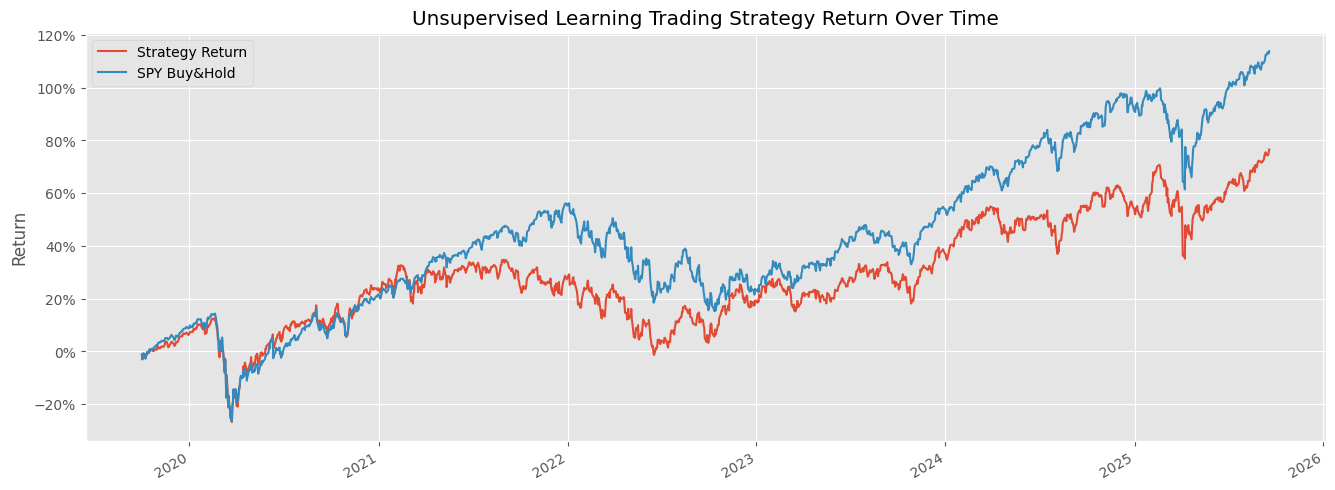

In [32]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return = (
    portfolio_cumulative_return[~portfolio_cumulative_return.index.duplicated(keep="first")]
    .sort_index()
)
portfolio_cumulative_return.plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')

plt.show()
